# Single Noteboook For End-To-End 
- Input Generation
- SA
- Heuristic

#### Importing Necessary Libraries

In [124]:
### Basic Imports
import numpy as np
import pandas as pd
import random
import toml
import os
import logging
import math
import json
from datetime import datetime
import seaborn as sns
### Matplot Lib Imports
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

### Parallel Processing Libraries
from functools import partial
import time
from concurrent.futures import ProcessPoolExecutor, as_completed,ThreadPoolExecutor
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import concurrent.futures

### Scipy Imports
from scipy.spatial import distance
from shapely.geometry import Point, MultiPoint
from shapely.ops import cascaded_union
from scipy.spatial import distance
from sklearn.cluster import KMeans
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.spatial.distance import cdist
### Other Imports
import warnings
from copy import deepcopy
from dataclasses import dataclass, field
from typing import List, Dict, Tuple, Any
from abc import ABC, abstractmethod
from matplotlib.colors import LinearSegmentedColormap


### Section - 1: Input Generation

#### Section - 1.1: Utility Functions

In [128]:
class LocationGenerator:
    def __init__(self, grid_size=120):
        self.grid_size = grid_size
        self.depot = np.array([grid_size/2, grid_size/2])
        self.charging_stations = []
        self.customers = []
        
    def calculate_distance(self, point1, point2):
        return np.sqrt(np.sum((point1 - point2) ** 2))
    
    def generate_charging_stations(self, num_stations):
        """Generate charging stations using circular distribution from depot"""
        self.charging_stations = []
        
        # Define multiple radius rings from depot
        # Using 3 rings: inner (15-25km), middle (25-40km), outer (40-55km)
        rings = [
            (15, 25),  # inner ring
            (25, 40),  # middle ring
            (40, 55)   # outer ring
        ]
        
        # Distribute stations across rings
        stations_per_ring = [
            num_stations // 3,                    # inner ring
            num_stations // 3,                    # middle ring
            num_stations - 2 * (num_stations // 3)  # outer ring (remaining stations)
        ]
        
        for ring_idx, (min_radius, max_radius) in enumerate(rings):
            stations_to_generate = stations_per_ring[ring_idx]
            attempts = 0
            max_attempts = 10000
            
            while len(self.charging_stations) < sum(stations_per_ring[:ring_idx + 1]) and attempts < max_attempts:
                # Generate random radius within ring bounds using triangular distribution
                # Mode is set to the middle of the ring for more natural distribution
                radius = np.random.triangular(
                    min_radius,
                    (min_radius + max_radius) / 2,
                    max_radius
                )
                
                # Generate random angle
                angle = np.random.uniform(0, 2 * np.pi)
                
                # Calculate position relative to depot
                x = self.depot[0] + radius * np.cos(angle)
                y = self.depot[1] + radius * np.sin(angle)
                
                # Clip to grid boundaries
                new_pos = np.clip(np.array([x, y]), 0, self.grid_size)
                
                # Check minimum distance from other stations
                valid = True
                min_station_distance = 25  # Minimum distance between stations
                
                for station in self.charging_stations:
                    if self.calculate_distance(new_pos, station) < min_station_distance:
                        valid = False
                        break
                
                # Additional check to ensure better coverage
                if valid and len(self.charging_stations) > 0:
                    # Calculate average distance to k-nearest stations
                    k = min(3, len(self.charging_stations))
                    distances = [self.calculate_distance(new_pos, station) 
                            for station in self.charging_stations]
                    distances.sort()
                    avg_nearest_distance = np.mean(distances[:k])
                    
                    # Prefer positions that maintain good spacing
                    if avg_nearest_distance < min_station_distance * 1.2:
                        valid = False
                
                if valid:
                    self.charging_stations.append(new_pos)
                
                attempts += 1
        
        if len(self.charging_stations) < num_stations:
            raise ValueError(f"Could only generate {len(self.charging_stations)} valid charging stations")
        
        return np.array(self.charging_stations)

    def is_valid_customer_location(self, point):
        """Check if a customer location is valid"""
        # Check depot distance (10-50 km)
        depot_dist = self.calculate_distance(point, self.depot)
        if not (10 <= depot_dist <= 60):
            return False
        
        # Check distance from other customers 5 km
        for customer in self.customers:
            dist = self.calculate_distance(point, customer)
            if dist < 10:
                return False
        
        # Check if at least one charging station is within 30 km
        has_station = False
        for station in self.charging_stations:
            dist = self.calculate_distance(point, station)
            if dist <= 35:
                has_station = True
                break
        
        return has_station
    
    def generate_customers_for_station(self, station, num_customers, existing_customers=None):
        """Generate customers with more varied distances from charging stations"""
        if existing_customers is None:
            existing_customers = []
                
        customers = []
        max_attempts = 1000
        attempts = 0
        
        # Instead of fixed circles, use random distances within the 30km limit
        while len(customers) < num_customers and attempts < max_attempts:
            # Generate random radius using triangular distribution
            # Mode at 20km to encourage spread, min at 5km, max at 30km
            radius = np.random.triangular(5, 15, 35)
            
            # Generate random angle
            angle = np.random.uniform(0, 7*np.pi)
            
            # Generate point
            x = station[0] + radius * np.cos(angle)
            y = station[1] + radius * np.sin(angle)
            point = np.array([x, y])
            point = np.clip(point, 0, self.grid_size)
            
            # Check validity with existing customers
            temp_customers = self.customers.copy()
            temp_customers.extend(customers)
            temp_customers.extend(existing_customers)
            
            # Create temporary generator to check validity
            temp_gen = LocationGenerator(self.grid_size)
            temp_gen.charging_stations = self.charging_stations
            temp_gen.customers = temp_customers
            
            if temp_gen.is_valid_customer_location(point):
                customers.append(point)
                
            attempts += 1
            
        return customers
    def generate_customers(self, num_customers):
        """Generate customers with inactive stations placed far from active ones"""
        self.customers = []
        
        # Calculate number of active stations (80%)
        num_stations = len(self.charging_stations)
        active_stations = int(np.ceil(0.9*num_stations))  # Round up for 70%
        
        # First, let's reorganize stations into active and inactive groups
        station_distances = []
        for i, station1 in enumerate(self.charging_stations):
            # Calculate sum of distances to other stations
            total_dist = sum(self.calculate_distance(station1, station2) 
                            for j, station2 in enumerate(self.charging_stations) if i != j)
            station_distances.append((i, total_dist))
        
        # Sort stations by their total distance to others
        station_distances.sort(key=lambda x: x[1])
        
        # Select the most clustered stations as active (they have smaller total distances)
        active_indices = [idx for idx, _ in station_distances[:active_stations]]
        inactive_indices = [idx for idx, _ in station_distances[active_stations:]]
        
        # Verify inactive stations are far enough (>30km) from active ones
        active_stations_list = [self.charging_stations[i] for i in active_indices]
        invalid_inactive = []
        
        for idx in inactive_indices:
            station = self.charging_stations[idx]
            for active_station in active_stations_list:
                if self.calculate_distance(station, active_station) <= 30:
                    invalid_inactive.append(idx)
                    break
        
        # If any inactive stations are too close, try to find better positions
        for idx in invalid_inactive:
            station = self.charging_stations[idx]
            attempts = 0
            max_attempts = 1000000
            while attempts < max_attempts:
                # Try a new position far from active stations
                new_pos = np.random.uniform(0, self.grid_size, 2)
                valid = True
                
                # Check distance from all active stations
                for active_station in active_stations_list:
                    if self.calculate_distance(new_pos, active_station) <= 30:
                        valid = False
                        break
                
                if valid:
                    self.charging_stations[idx] = new_pos
                    break
                    
                attempts += 1
        
        # Now generate customers around active stations only
        all_customers = []
        customers_per_station = num_customers // len(active_indices)
        extra_customers = num_customers % len(active_indices)
        
        for i, station_idx in enumerate(active_indices):
            station = self.charging_stations[station_idx]
            # Add one extra customer to some stations if needed
            station_customers = customers_per_station + (1 if i < extra_customers else 0)
            
            new_customers = self.generate_customers_for_station(
                station,
                station_customers,
                all_customers
            )
            
            all_customers.extend(new_customers)
        
        if len(all_customers) < num_customers:
            raise ValueError(f"Could only generate {len(all_customers)} valid customer locations")
        
        self.customers = all_customers
        return np.array(all_customers)
    
    def generate_locations(self, num_customers, num_stations):
        """Generate complete location set starting with charging stations"""
        # First generate charging stations
        charging_stations = self.generate_charging_stations(num_stations)
        if len(charging_stations) < num_stations:
            raise ValueError(f"Could only generate {len(charging_stations)} charging stations")
        
        # Then generate customers around stations
        customers = self.generate_customers(num_customers)
        
        return customers, charging_stations
    
    def visualize(self, title="Location Distribution", show_coverage=True):
        plt.figure(figsize=(12, 12))
        
        # Plot depot and its range
        plt.plot(self.depot[0], self.depot[1], 'k^', markersize=15, label='Depot')
        depot_inner = plt.Circle((self.depot[0], self.depot[1]), 10, color='k', fill=False, alpha=0.1)
        depot_outer = plt.Circle((self.depot[0], self.depot[1]), 50, color='k', fill=False, alpha=0.1)
        plt.gca().add_patch(depot_inner)
        plt.gca().add_patch(depot_outer)
        
        # Plot charging stations and their coverage
        station_array = np.array(self.charging_stations)
        plt.plot(station_array[:, 0], station_array[:, 1], 'rs', markersize=10, label='Charging Stations')
        
        if show_coverage:
            for station in station_array:
                circle = plt.Circle((station[0], station[1]), 15, color='r', fill=False, alpha=0.1)
                plt.gca().add_patch(circle)
        
        # Plot customers with connections to nearest station
        customer_array = np.array(self.customers)
        plt.plot(customer_array[:, 0], customer_array[:, 1], 'bo', label='Customers')
        
        # Show station-customer assignments
        for customer in customer_array:
            nearest_station = min(station_array, 
                                key=lambda s: self.calculate_distance(customer, s))
            plt.plot([customer[0], nearest_station[0]], 
                    [customer[1], nearest_station[1]], 
                    'g--', alpha=0.1)
        
        plt.grid(True)
        plt.legend()
        plt.title(title)
        plt.xlabel('X coordinate (km)')
        plt.ylabel('Y coordinate (km)')
        plt.axis('equal')
        plt.xlim(0, self.grid_size)
        plt.ylim(0, self.grid_size)
        return plt.gcf()

In [129]:
def get_test_case_path(base_directory, num_customers, instance_id):
    """Generate path for test case files"""
    customer_dir = os.path.join(base_directory, f"customers_{num_customers}")
    case_base = f"c{num_customers}_{instance_id}"
    return {
        'directory': customer_dir,
        'toml_path': os.path.join(customer_dir, f"{case_base}.toml"),
        'viz_path': os.path.join(customer_dir, f"{case_base}_viz.png"),
        'case_id': case_base
    }

def check_existing_test_cases(base_directory, num_customers, instances_per_count):
    """Check which test cases already exist"""
    customer_dir = os.path.join(base_directory, f"customers_{num_customers}")
    if not os.path.exists(customer_dir):
        return []
    
    existing_cases = []
    for i in range(1, instances_per_count + 1):
        paths = get_test_case_path(base_directory, num_customers, i)
        if os.path.exists(paths['toml_path']) and os.path.exists(paths['viz_path']):
            existing_cases.append(i)
    
    return existing_cases

def generate_test_case(num_customers, instance_id, base_directory):
    """Generate a single test case"""
    # Get paths for this test case
    paths = get_test_case_path(base_directory, num_customers, instance_id)
    
    # Create directory if it doesn't exist
    os.makedirs(paths['directory'], exist_ok=True)
    
    # Calculate number of stations based on customer count
    num_stations = 10
    
    generator = LocationGenerator()
    customers, charging_stations = generator.generate_locations(num_customers, num_stations)
    
    # Generate random weights (50-100 kg, multiple of 5)
    customer_items_weights = np.random.randint(10, 21, size=num_customers) * 5
    
    test_case = {
        "instance_id": paths['case_id'],
        "num_customers": num_customers,
        "depot_location": generator.depot.tolist(),
        "customer_locations": customers.tolist(),
        "charging_stations": charging_stations.tolist(),
        "customer_items_weights": customer_items_weights.tolist(),
        "vehicle_speed": 25,
        "charging_rate": 22,
        "ev_parameters": {
            "small": {
                "battery_capacity": 35,
                "base_weight": 1500,
                "load_capacity": 500
            },
            "medium": {
                "battery_capacity": 40,
                "base_weight": 1800,
                "load_capacity": 600
            },
            "large": {
                "battery_capacity": 45,
                "base_weight": 2000,
                "load_capacity": 700
            },
            "xlarge": {
                "battery_capacity": 50,
                "base_weight": 2200,
                "load_capacity": 800
            }
        }
    }
    
    # Save test case
    with open(paths['toml_path'], 'w') as f:
        toml.dump(test_case, f)
    
    # Save visualization
    fig = generator.visualize(f"Test Case: {test_case['instance_id']}")
    plt.savefig(paths['viz_path'])
    plt.close()
    
    return test_case

def main():
    base_directory = '../test_cases'
    customer_counts = [10,20,30,40,50]
    instances_per_count = 20
    
    all_test_cases = []
    
    # Create base directory if it doesn't exist
    os.makedirs(base_directory, exist_ok=True)
    
    for num_customers in customer_counts:
        print(f"\nProcessing test cases for {num_customers} customers:")
        
        # Check existing test cases
        existing_cases = check_existing_test_cases(base_directory, num_customers, instances_per_count)
        remaining_instances = set(range(1, instances_per_count + 1)) - set(existing_cases)
        
        if not remaining_instances:
            print(f"- All {instances_per_count} test cases already exist for {num_customers} customers")
            # Load existing test cases
            for i in range(1, instances_per_count + 1):
                paths = get_test_case_path(base_directory, num_customers, i)
                with open(paths['toml_path'], 'r') as f:
                    test_case = toml.load(f)
                    all_test_cases.append(test_case)
            continue
        
        print(f"- Generating {len(remaining_instances)} new test cases for {num_customers} customers")
        for instance in remaining_instances:
            try:
                test_case = generate_test_case(num_customers, instance, base_directory)
                all_test_cases.append(test_case)
                print(f"  - Generated test case {instance}/{instances_per_count}")
            except Exception as e:
                print(f"  - Error generating test case {instance}: {str(e)}")
    
    # Print summary
    print("\nTest Case Generation Summary:")
    for num_customers in customer_counts:
        customer_dir = os.path.join(base_directory, f"customers_{num_customers}")
        if os.path.exists(customer_dir):
            count = len([f for f in os.listdir(customer_dir) if f.endswith('.toml')])
            print(f"- {num_customers} customers: {count} valid test cases available")
    
    return all_test_cases


#### Section - 1.2: Generating Test Cases

In [130]:
if __name__ == "__main__":
    test_cases = main()


Processing test cases for 10 customers:
- Generating 20 new test cases for 10 customers
  - Generated test case 1/20
  - Generated test case 2/20
  - Generated test case 3/20
  - Generated test case 4/20
  - Generated test case 5/20
  - Generated test case 6/20
  - Generated test case 7/20
  - Generated test case 8/20
  - Generated test case 9/20
  - Generated test case 10/20
  - Generated test case 11/20
  - Generated test case 12/20
  - Generated test case 13/20
  - Generated test case 14/20
  - Generated test case 15/20
  - Generated test case 16/20
  - Generated test case 17/20
  - Generated test case 18/20
  - Generated test case 19/20
  - Generated test case 20/20

Processing test cases for 20 customers:
- Generating 20 new test cases for 20 customers
  - Generated test case 1/20
  - Generated test case 2/20
  - Generated test case 3/20
  - Generated test case 4/20
  - Generated test case 5/20
  - Generated test case 6/20
  - Generated test case 7/20
  - Generated test case 8/20

#### Section - 1.3: Plotting Random Test Cases

In [131]:
def load_test_case(filename):
    """Load a test case from a TOML file"""
    with open(filename, 'r') as f:
        return toml.load(f)

def plot_locations(test_case, title):
    """Plot locations from a test case with enhanced visualization"""
    # Extract locations
    depot = test_case['depot_location']
    customers = test_case['customer_locations']
    stations = test_case['charging_stations']
    
    # Combine all coordinates for determining plot bounds
    all_points = np.array([depot] + customers + stations)
    min_x, max_x = all_points[:, 0].min(), all_points[:, 0].max()
    min_y, max_y = all_points[:, 1].min(), all_points[:, 1].max()
    
    # Add margin to bounds
    margin = max(max_x - min_x, max_y - min_y) * 0.1
    
    fig, ax = plt.subplots(figsize=(16, 12))
    
    # Create custom background
    custom_cmap = LinearSegmentedColormap.from_list("custom", ["#E6F3FF", "#B3E0FF", "#80CCFF"])
    x = np.outer(np.linspace(0, 1, 256), np.ones(256))
    ax.imshow(x, cmap=custom_cmap, aspect='auto', 
              extent=[min_x-margin, max_x+margin, min_y-margin, max_y+margin])
    
    # Plot customers
    customer_x, customer_y = zip(*customers)
    ax.scatter(customer_x, customer_y, c='#1E90FF', marker='o', 
              label='Customers', s=150, edgecolors='white', 
              linewidths=1, alpha=0.8, zorder=3)
    
    # Plot charging stations
    station_x, station_y = zip(*stations)
    ax.scatter(station_x, station_y, c='#FF4500', marker='s', 
              label='Charging Stations', s=200, edgecolors='white', 
              linewidths=1, zorder=4)
    
    # Plot depot
    ax.scatter(depot[0], depot[1], c='#32CD32', marker='^', 
              label='Depot', s=300, edgecolors='black', 
              linewidths=2, zorder=5)
    
    # Enhance plot aesthetics
    ax.set_title(title, fontsize=24, fontweight='bold', pad=20)
    ax.set_xlabel('X Coordinate (km)', fontsize=16, labelpad=10)
    ax.set_ylabel('Y Coordinate (km)', fontsize=16, labelpad=10)
    ax.grid(color='white', linestyle='--', linewidth=0.8, alpha=0.5)
    
    # Enhance legend
    legend = ax.legend(loc='upper right', fontsize=14, frameon=True, 
                      framealpha=0.9, edgecolor='gray')
    legend.get_frame().set_facecolor('white')
    
    # Enhance spines
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('gray')
        spine.set_linewidth(0.5)
    
    plt.tight_layout()
    return fig

def get_available_test_cases(base_directory='../test_cases'):
    """Get all available test cases grouped by customer count"""
    test_cases = {}
    
    # Walk through the test_cases directory
    for dirname in os.listdir(base_directory):
        if dirname.startswith('customers_'):
            customer_count = int(dirname.split('_')[1])
            customer_dir = os.path.join(base_directory, dirname)
            
            # Get all TOML files in this directory
            toml_files = [f for f in os.listdir(customer_dir) if f.endswith('.toml')]
            test_cases[customer_count] = [os.path.join(customer_dir, f) for f in toml_files]
    
    return test_cases

def plot_random_test_cases(base_directory='../test_cases', num_plots=3):
    """Plot random test cases for each customer count"""
    available_cases = get_available_test_cases(base_directory)
    
    if not available_cases:
        print("No test cases found!")
        return
    
    for customer_count, case_files in available_cases.items():
        print(f"\nCustomer count: {customer_count}")
        
        # Select random cases for this customer count
        selected_files = random.sample(case_files, min(num_plots, len(case_files)))
        
        for filename in selected_files:
            test_case = load_test_case(filename)
            case_id = test_case['instance_id']
            
            # Create title with relevant information
            title = (f"Test Case: {case_id}\n"
                    f"Customers: {len(test_case['customer_locations'])}, "
                    f"Charging Stations: {len(test_case['charging_stations'])}")
            
            # Plot and display
            fig = plot_locations(test_case, title)
            plt.show()
            plt.close()
            
            # Print additional information
            print(f"\nPlotted: {os.path.basename(filename)}")
            print(f"Number of customers: {len(test_case['customer_locations'])}")
            print(f"Number of charging stations: {len(test_case['charging_stations'])}")
            print("Total customer demand:", sum(test_case['customer_items_weights']))
            print("--------------------")


Customer count: 10


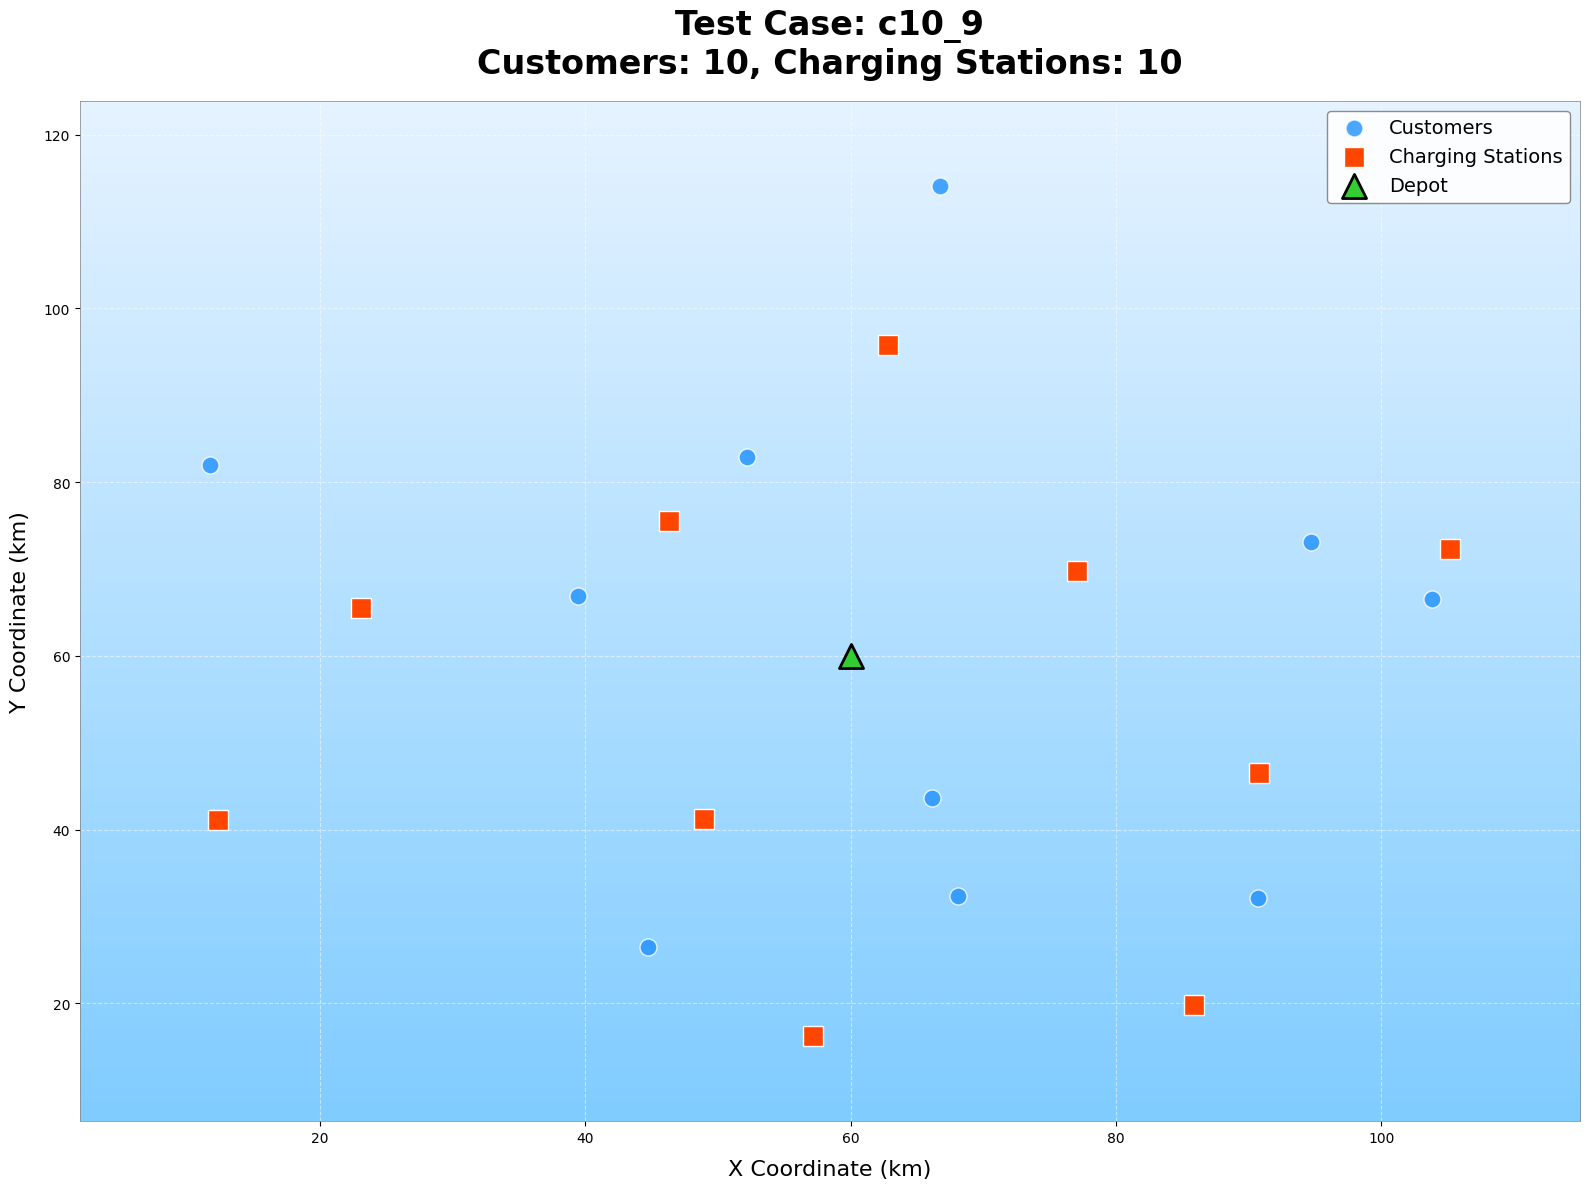


Plotted: c10_9.toml
Number of customers: 10
Number of charging stations: 10
Total customer demand: 785
--------------------


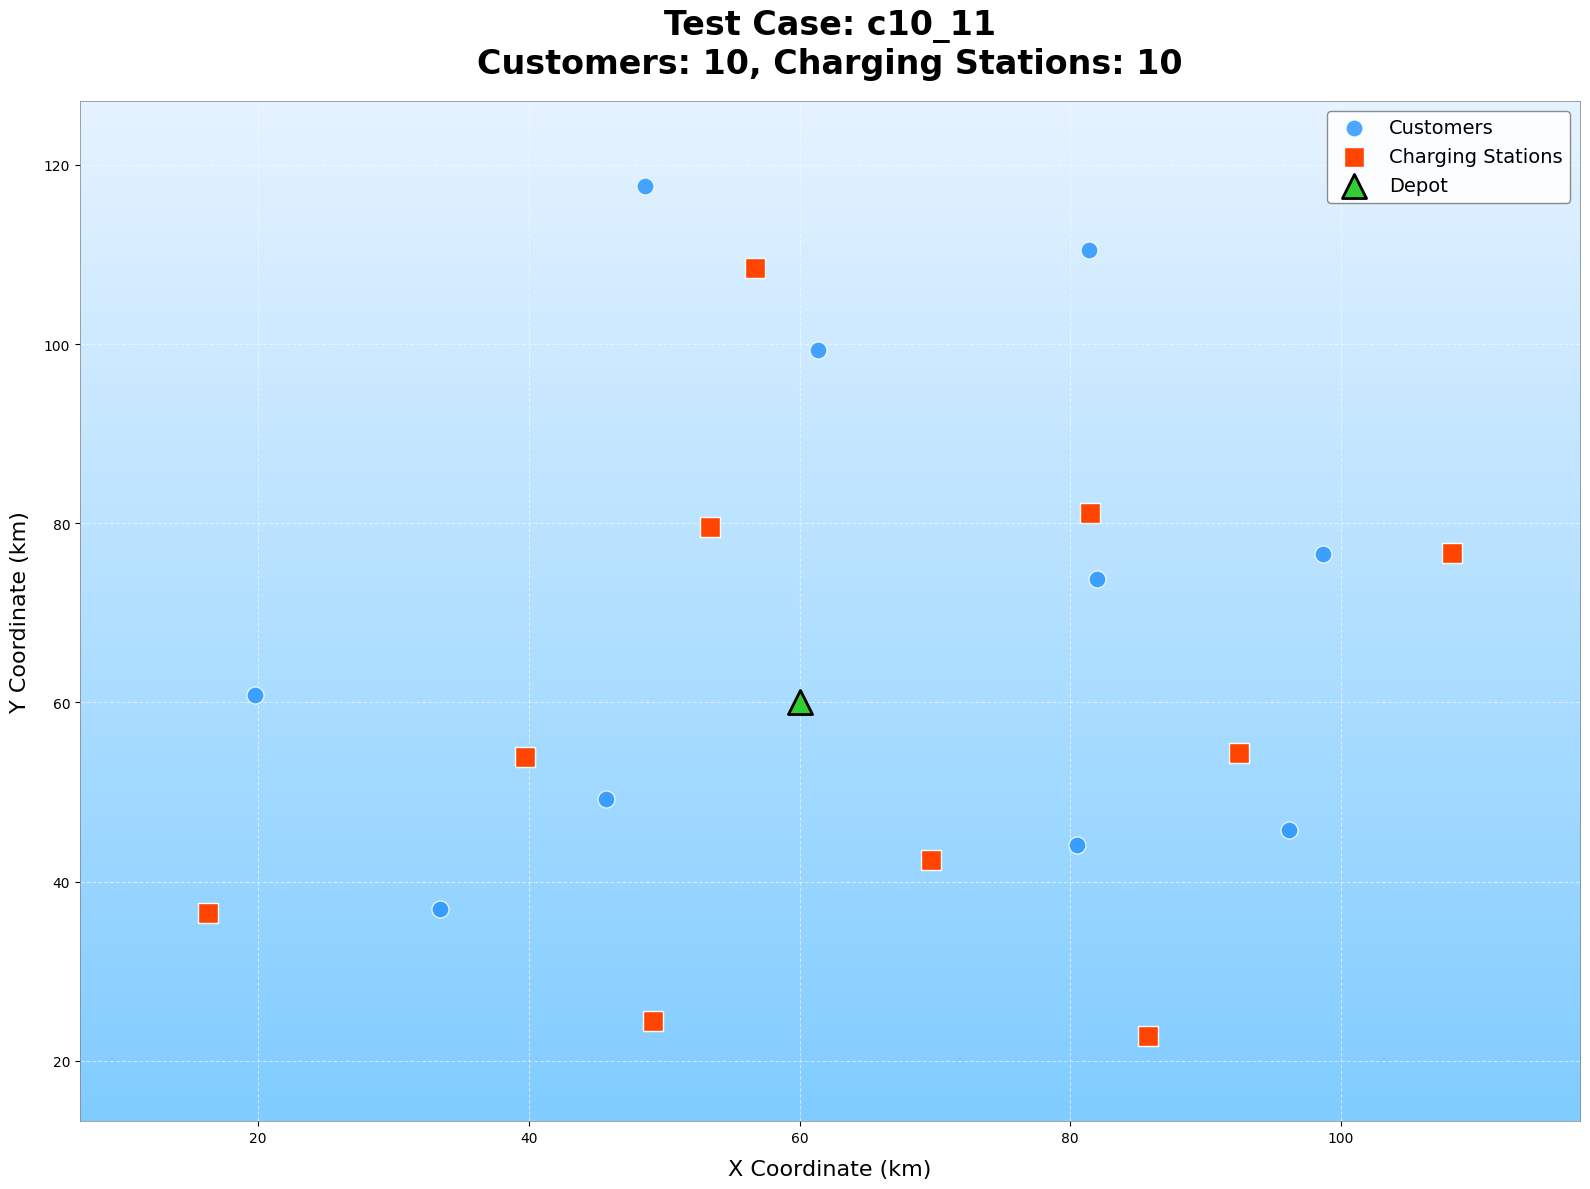


Plotted: c10_11.toml
Number of customers: 10
Number of charging stations: 10
Total customer demand: 715
--------------------

Customer count: 20


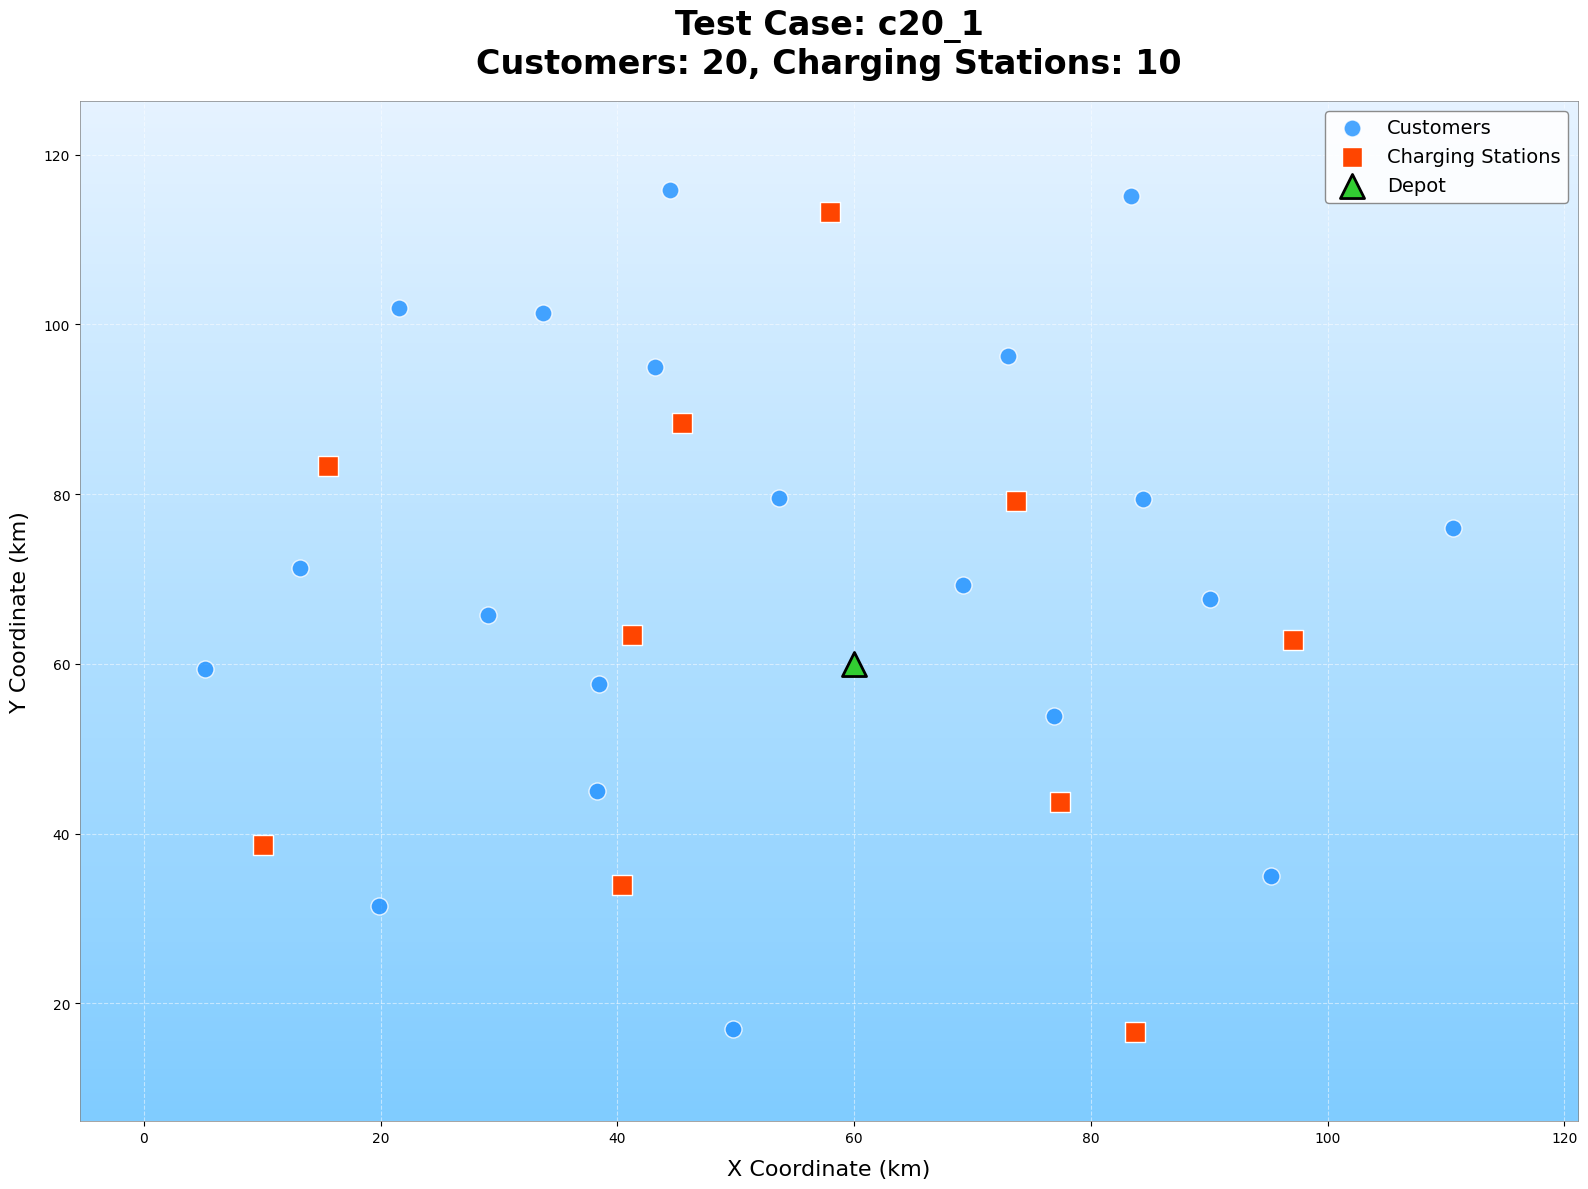


Plotted: c20_1.toml
Number of customers: 20
Number of charging stations: 10
Total customer demand: 1585
--------------------


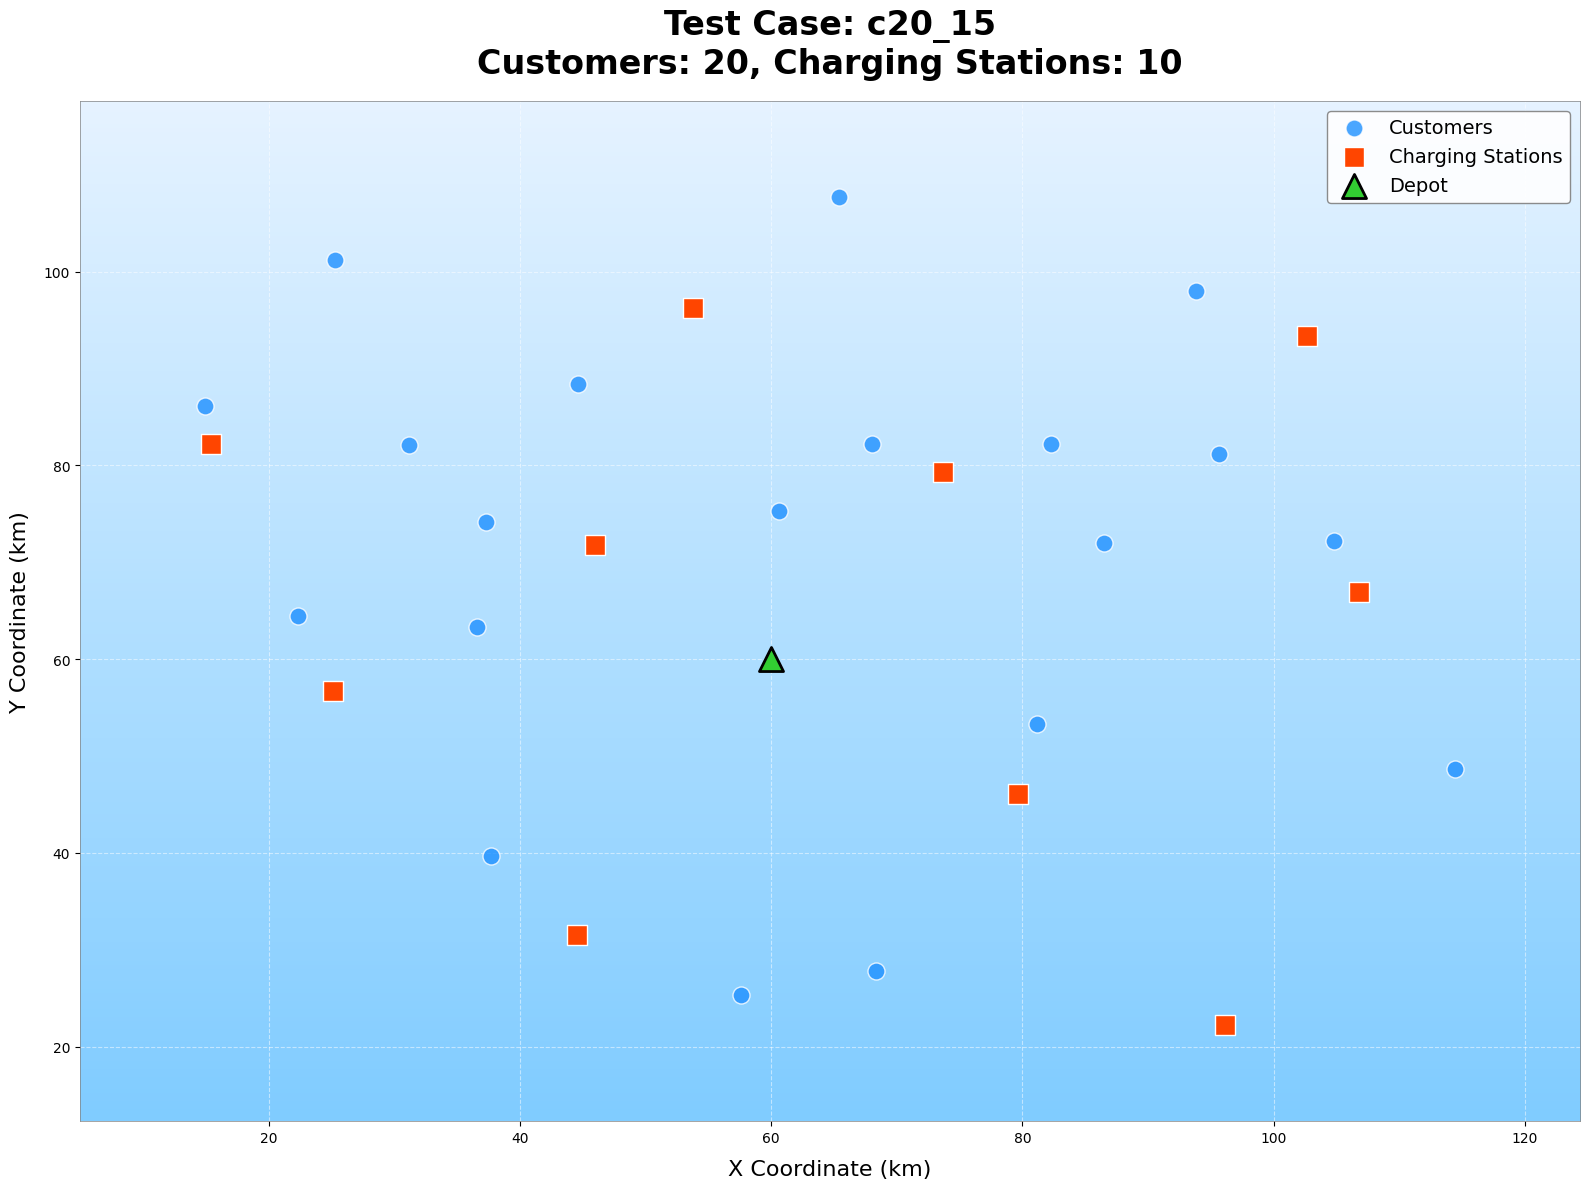


Plotted: c20_15.toml
Number of customers: 20
Number of charging stations: 10
Total customer demand: 1650
--------------------

Customer count: 50


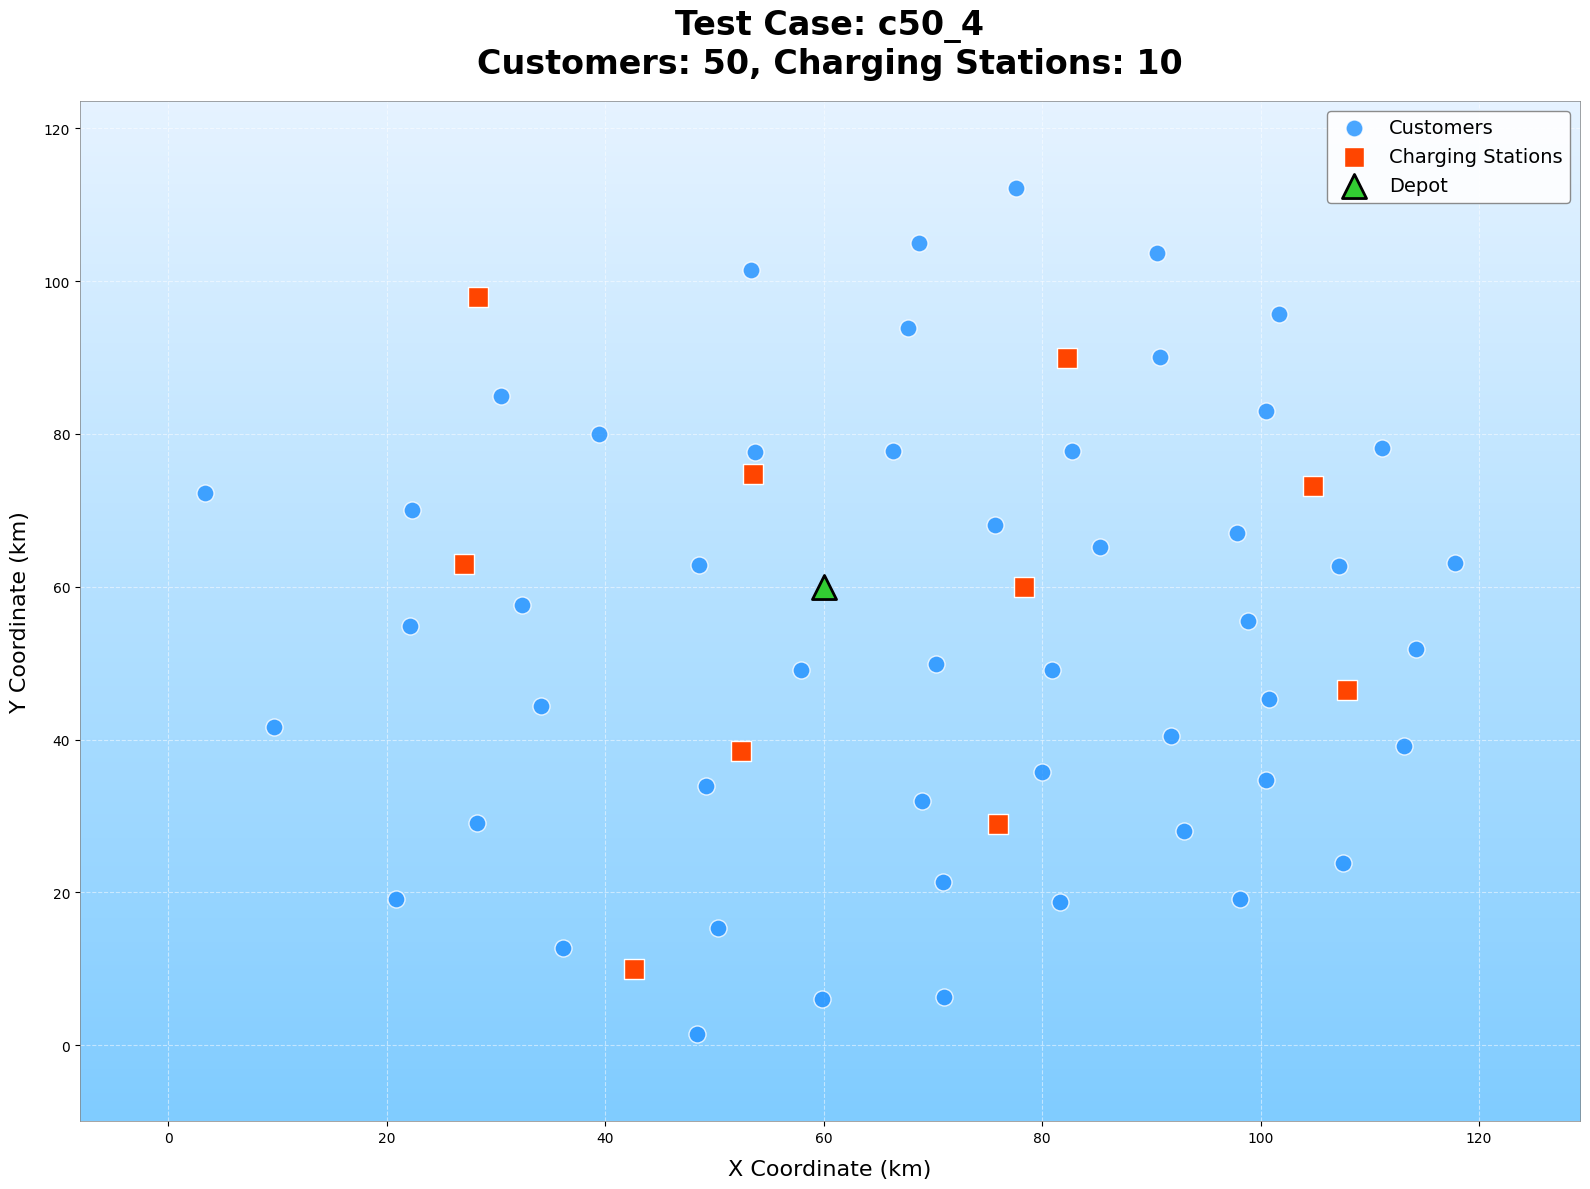


Plotted: c50_4.toml
Number of customers: 50
Number of charging stations: 10
Total customer demand: 3685
--------------------


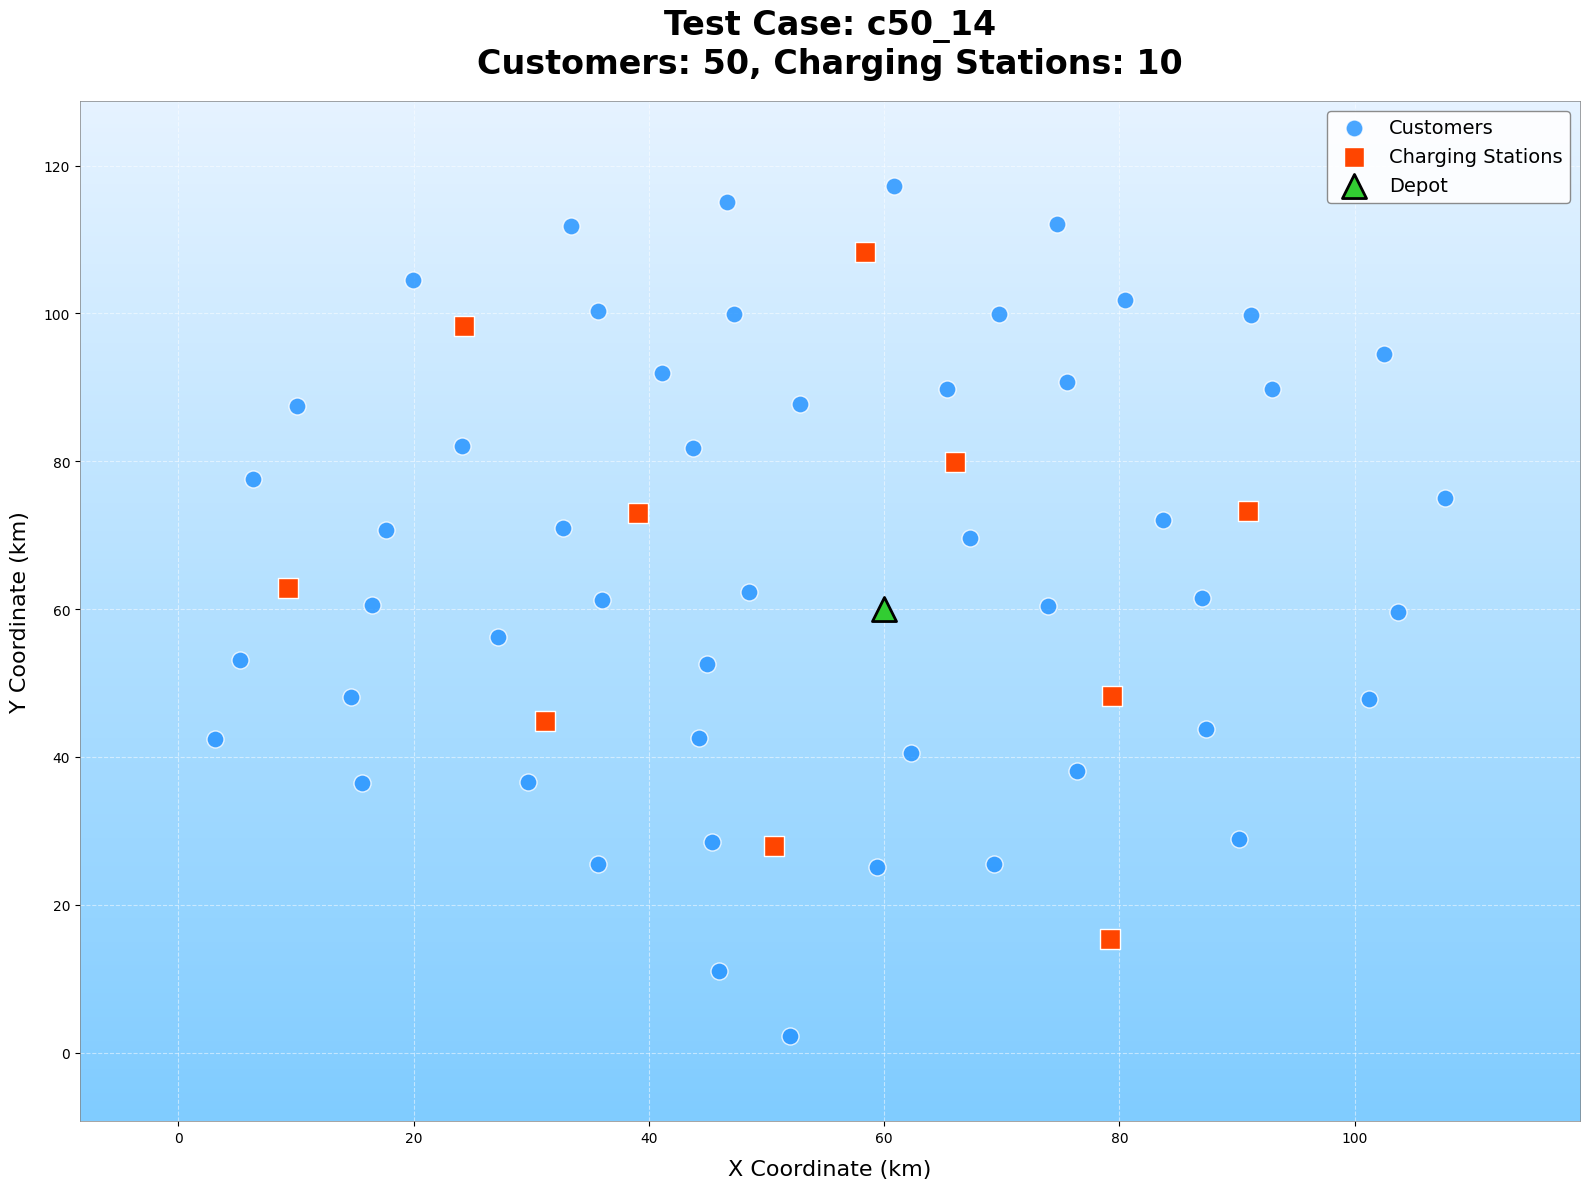


Plotted: c50_14.toml
Number of customers: 50
Number of charging stations: 10
Total customer demand: 3575
--------------------

Customer count: 40


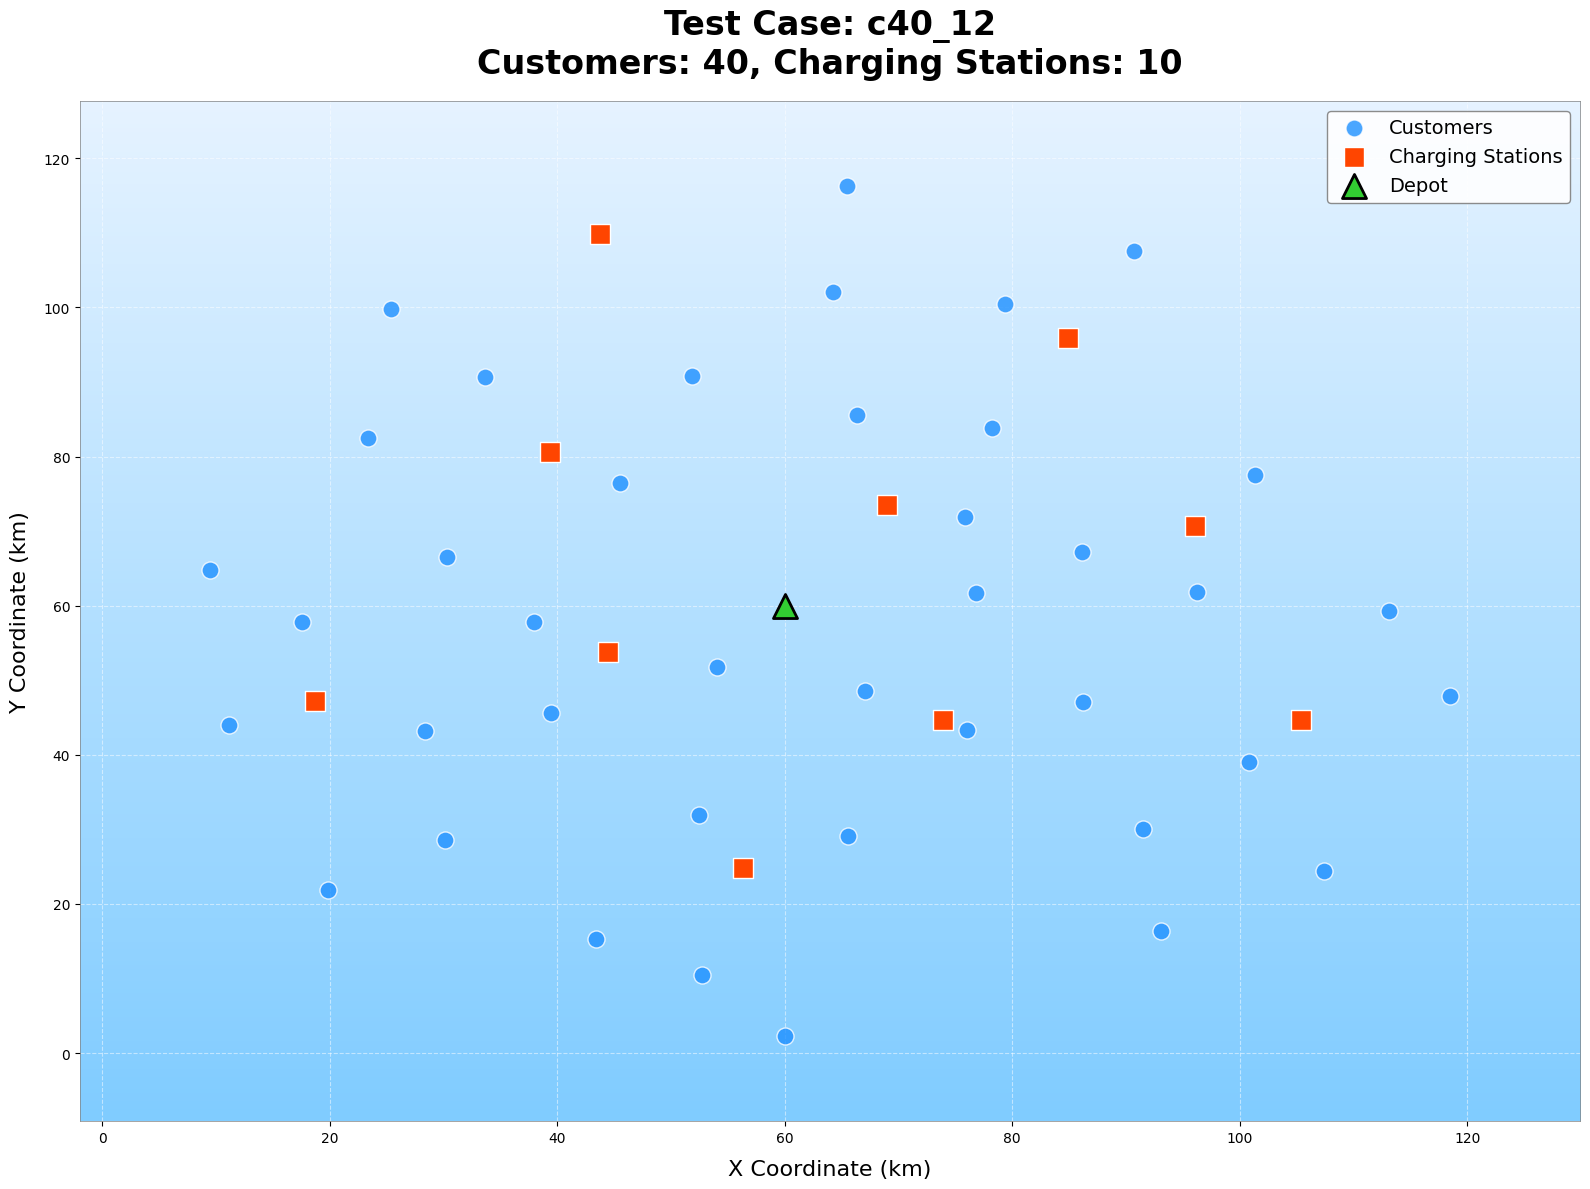


Plotted: c40_12.toml
Number of customers: 40
Number of charging stations: 10
Total customer demand: 3165
--------------------


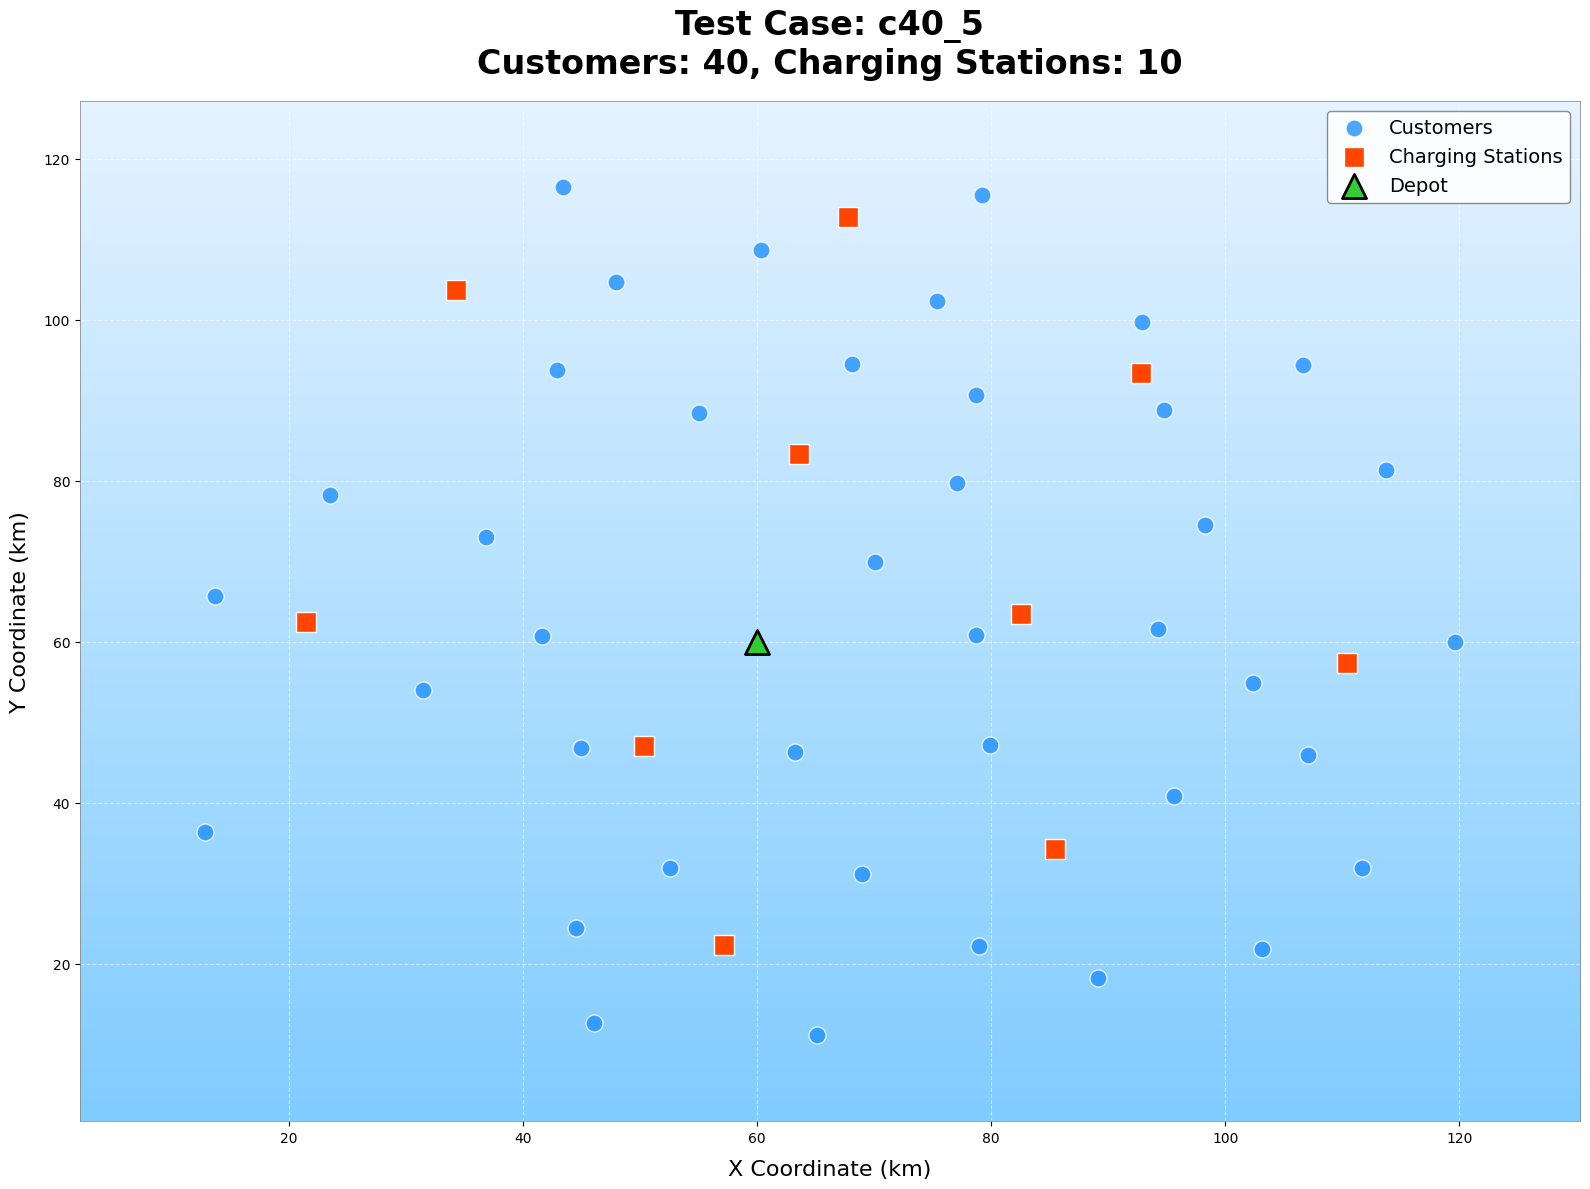


Plotted: c40_5.toml
Number of customers: 40
Number of charging stations: 10
Total customer demand: 3010
--------------------

Customer count: 30


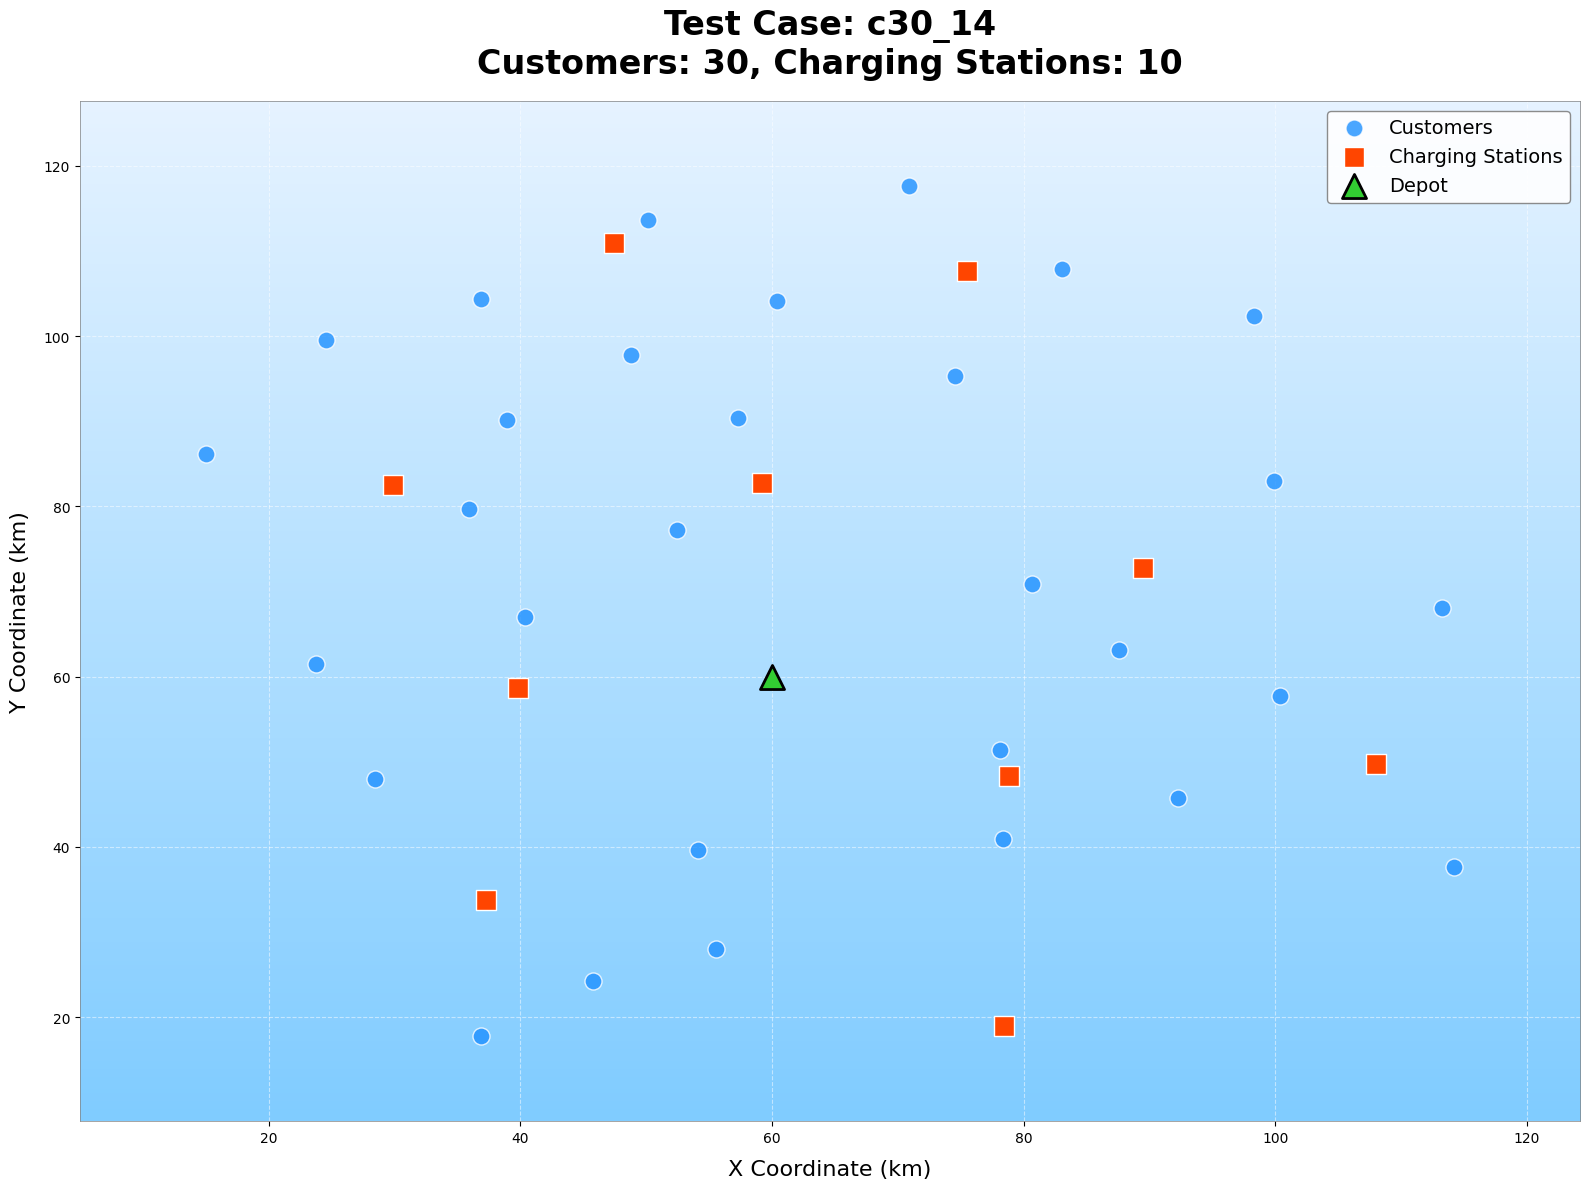


Plotted: c30_14.toml
Number of customers: 30
Number of charging stations: 10
Total customer demand: 2390
--------------------


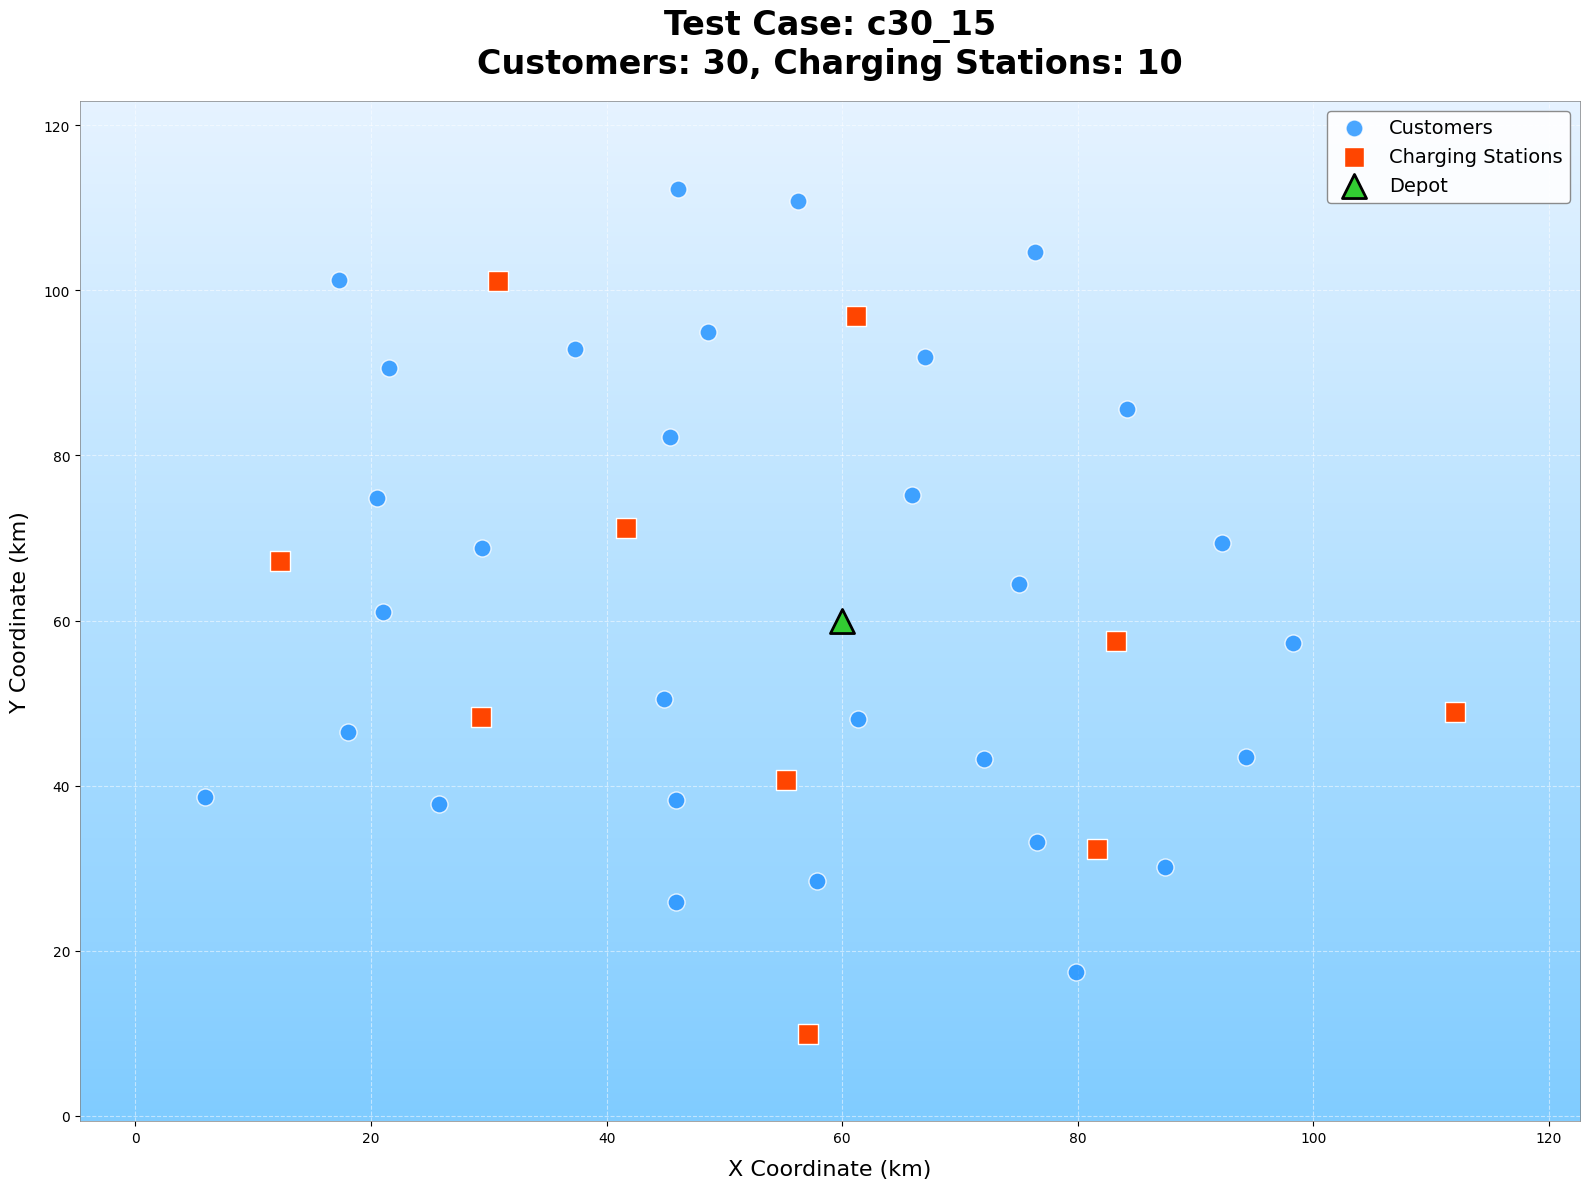


Plotted: c30_15.toml
Number of customers: 30
Number of charging stations: 10
Total customer demand: 2435
--------------------


In [132]:

if __name__ == "__main__":
    # Example usage
    plot_random_test_cases(num_plots=2)

### Section - 2: Algorithms

#### Bases Classes

In [133]:
class Tour:
    def __init__(self, num_drones):
        self.routes = [[] for _ in range(num_drones)]
        self.travel_costs = [0 for _ in range(num_drones)]
        self.delay_costs = [0 for _ in range(num_drones)]
        self.battery_levels = [[] for _ in range(num_drones)]

In [134]:
class RoutingAlgorithmBaseEV:
    def __init__(self):
        self.best_solution = None

    def Set_EV_Parameters(self):
        """
        Set up EV parameters with dynamic vehicle selection capability and flexible fleet size
        """
        self.initial_charging = 100  # Start with full battery
        self.ev_speed = 25  # km/h (constant speed)
        
        # Define all EV categories and their specifications
        self.ev_categories = {
            'small': {
                'battery_capacity': 35,    # kWh
                'base_weight': 1500,       # kg
                'load_capacity': 500,      # kg
                'empty_consumption': 0.225, # kWh/km
                'full_consumption': 0.25,   # kWh/km
                'max_range': 112,          # km
                'min_range': 28            # km
            },
            'medium': {
                'battery_capacity': 40,     # kWh
                'base_weight': 1800,        # kg
                'load_capacity': 600,       # kg
                'empty_consumption': 0.24,  # kWh/km
                'full_consumption': 0.27,   # kWh/km
                'max_range': 118.5,        # km
                'min_range': 29.6          # km
            },
            'large': {
                'battery_capacity': 45,     # kWh
                'base_weight': 2000,        # kg
                'load_capacity': 700,       # kg
                'empty_consumption': 0.25,  # kWh/km
                'full_consumption': 0.285,  # kWh/km
                'max_range': 126.3,        # km
                'min_range': 31.6          # km
            },
            'xlarge': {
                'battery_capacity': 50,     # kWh
                'base_weight': 2200,        # kg
                'load_capacity': 800,       # kg
                'empty_consumption': 0.26,  # kWh/km
                'full_consumption': 0.30,   # kWh/km
                'max_range': 133.3,        # km
                'min_range': 33.3          # km
            }
        }
        
        # Energy consumption parameters
        self.energy_consumption_rate = 0.15  # Base rate in kWh/km
        self.weight_factor = 0.05           # Additional consumption per 1000kg
        self.battery_safety_margin = 20     # Minimum battery level (%)
        
        print("\nEV Fleet Configuration:")
        print("Dynamic vehicle selection enabled")
        print("Flexible fleet size enabled")
        print("\nAvailable Vehicle Categories:")
        for category, specs in self.ev_categories.items():
            print(f"\n{category.upper()}:")
            print(f"Load Capacity: {specs['load_capacity']} kg")
            print(f"Max Range: {specs['max_range']} km")


    def Set_Charging_Station_Parameters(self, charging_rate, charging_cost):
        """Set parameters for charging stations"""
        self.charging_rate = charging_rate
        self.charging_cost = charging_cost

    def Set_Tour_Parameters(self, distance_matrix, distance_between_charging_stations_customers, 
                          num_evs, customer_locations, charging_station_locations):
        """Set parameters for the delivery tour"""
        self.number_of_customers = len(distance_matrix) - 1
        self.number_of_charging_stations = len(distance_between_charging_stations_customers[0])
        self.distance_matrix = distance_matrix
        self.distance_between_charging_stations_customers = distance_between_charging_stations_customers
        self.number_of_evs = num_evs
        self.customer_locations = customer_locations
        self.charging_station_locations = charging_station_locations

    def Set_Customer_Parameters(self, customer_items_weights, customer_deadlines):
        """Set parameters related to customers"""
        self.customer_items_weights = customer_items_weights
        self.customer_deadlines = customer_deadlines

    def Discharging_Rate_Per_KM(self, load):
        """Calculate battery discharge rate per km based on load"""
        # Basic energy consumption model for EVs
        base_consumption = self.energy_consumption_rate  # Base consumption rate
        weight_factor = 0.05  # Additional consumption per kg of load
        total_weight = self.ev_base_weight + load
        
        power_consumption = base_consumption + (self.ev_base_weight+load) * weight_factor/1000
        # This Rate is in KWh/Km not percentage
        return (power_consumption / self.ev_battery_capacity) 

    def calculate_delivery_time(self, route):
        """Calculate total delivery time for a route including travel and charging times"""
        total_time = 0
        current_load = sum(self.customer_items_weights.get(str(customer - 1), 0) 
                        for customer in route if customer > 0)
        
        for i in range(len(route) - 1):
            current_location = route[i]
            next_location = route[i + 1]
            
            # Calculate travel time
            distance = self.calculate_distance(current_location, next_location)
            travel_time = distance / self.ev_speed
            total_time += travel_time
            
            # Add charging time if at charging station
            if current_location < 0:  # Charging station
                charging_time = self.ev_battery_capacity / self.charging_rate
                total_time += charging_time
                
            # Update load after delivery
            if current_location > 0:  # If current location is a customer
                current_load -= self.customer_items_weights.get(str(current_location - 1), 0)
        
        return total_time

    def calculate_fitness(self, tour):
        """
        Calculate fitness by minimizing maximum delivery time among all EVs
        Returns the maximum delivery time across all routes
        """
        delivery_times = []
        
        # Calculate delivery time for each route
        for route in tour.routes:
            delivery_time = self.calculate_delivery_time(route)
            delivery_times.append(delivery_time)
            
        # Store individual delivery times for analysis
        tour.delivery_times = delivery_times
        
        # Fitness is the maximum delivery time (to be minimized)
        max_delivery_time = max(delivery_times) if delivery_times else float('inf')
        
        return max_delivery_time
    def calculate_travel_cost(self, route):
        """Calculate total travel cost for a route"""
        total_distance = 0    
        for i in range(len(route) - 1):
            current_location = route[i]
            next_location = route[i + 1]
            
            distance = self.calculate_distance(current_location, next_location)
            total_distance += distance
            
        return total_distance

    def calculate_delay_cost(self, route):
        """Calculate delay cost for a route"""
        delay_cost = 0
        current_time = 0
        
        for i in range(1, len(route) - 1):
            current_location = route[i]
            if current_location > 0:  # Customer location
                deadline = self.customer_deadlines[str(current_location - 1)]
                if current_time > deadline:
                    delay_cost += current_time - deadline
            
            next_location = route[i + 1]
            if current_location < 0:  # Charging station
                charging_time = self.ev_battery_capacity / self.charging_rate
                current_time += charging_time
            else:
                distance = self.calculate_distance(current_location, next_location)
                current_time += distance / self.ev_speed
        
        return delay_cost * self.ev_speed

    def find_nearest_charging_station(self, current_location):
        """Find the nearest charging station to the current location"""
        nearest_charging_station = 0
        min_distance = float('inf')
        
        for charging_station in range(self.number_of_charging_stations):
            distance = self.distance_between_charging_stations_customers[current_location][charging_station]
            if distance < min_distance:
                min_distance = distance
                nearest_charging_station = charging_station
                
        return nearest_charging_station

    def calculate_power_needed(self, from_location, to_location, load):
        """Calculate power needed for travel between locations"""
        distance = self.calculate_distance(from_location, to_location)
        return self.Discharging_Rate_Per_KM(load) * distance

    def insert_charging_stations(self, route):
        """Insert charging stations into a route where needed"""
        new_route = [0]  # Start at depot
        current_battery = self.initial_charging
        battery_safety_margin = 20  # 20% safety margin
        
        # Calculate initial load
        current_load = sum(self.customer_items_weights.get(str(customer - 1), 0) 
                         for customer in route if customer > 0)
        
        for i in range(1, len(route)):
            current_location = route[i]
            power_needed = self.calculate_power_needed(new_route[-1], current_location, current_load)
            
            # Check if charging is needed
            if current_battery - power_needed < max(self.initial_charging * (battery_safety_margin / 100), 
                                                  power_needed * 1.5):
                if new_route[-1] >= 0:
                    nearest_charging_station = self.find_nearest_charging_station(new_route[-1])
                    if nearest_charging_station is None:
                        raise ValueError(f"No charging station found near location {new_route[-1]}")
                    new_route.append(-(nearest_charging_station + 1))
                    current_battery = self.initial_charging
                    power_needed = self.calculate_power_needed(-(nearest_charging_station + 1), 
                                                            current_location, current_load)
            
            new_route.append(current_location)
            current_battery -= power_needed
            
            # Update load after delivery
            if current_location > 0:
                current_load = max(0, current_load - self.customer_items_weights.get(str(current_location - 1), 0))
        
        # Check if final charging needed for return to depot
        final_power_needed = self.calculate_power_needed(new_route[-1], 0, current_load)
        if current_battery - final_power_needed < self.initial_charging * (battery_safety_margin / 100):
            nearest_charging_station = self.find_nearest_charging_station(new_route[-1])
            if nearest_charging_station is not None:
                new_route.append(-(nearest_charging_station + 1))
        
        return new_route

    def calculate_distance(self, from_location, to_location):
        """Calculate distance between two locations"""
        if from_location >= 0 and to_location >= 0:
            return self.distance_matrix[from_location][to_location]
        elif from_location < 0 and to_location >= 0:
            charging_station_index = -from_location - 1
            return self.distance_between_charging_stations_customers[to_location][charging_station_index]
        elif from_location >= 0 and to_location < 0:
            charging_station_index = -to_location - 1
            return self.distance_between_charging_stations_customers[from_location][charging_station_index]
        else:
            print(f"Warning: Invalid route segment from {from_location} to {to_location}")
            return 0

#### Section  2.1 : Simulated Annealing

In [135]:
class SimulatedAnnealingEV(RoutingAlgorithmBaseEV):
    def __init__(self, initial_temperature=1000, cooling_rate=0.95, 
                 min_temperature=1, iterations_per_temp=100):
        super().__init__()
        self.initial_temperature = initial_temperature
        self.cooling_rate = cooling_rate
        self.min_temperature = min_temperature
        self.iterations_per_temp = iterations_per_temp
        self.best_fitness_history = []

    def initialize_solution(self):
        """Initialize solution with dynamic fleet size and vehicle selection"""
        customers = list(range(1, self.number_of_customers + 1))
        routes = []  # Dynamic list of routes
        
        while customers:
            # Create a new route
            route_customers = []
            current_load = 0
            available_time = 8 * 60  # 8-hour shift in minutes
            last_location = 0  # depot
            
            # Try to add customers to current route
            remaining_customers = customers.copy()
            while remaining_customers:
                # Find closest unassigned customer
                next_customer = min(remaining_customers, 
                                key=lambda c: self.calculate_distance(last_location, c))
                
                # Calculate additional load
                additional_load = self.customer_items_weights.get(str(next_customer - 1), 0)
                tentative_load = current_load + additional_load
                
                # Find smallest suitable vehicle for tentative load
                try:
                    category = self.select_ev_category(tentative_load, 
                                                    self.calculate_max_segment_distance(route_customers + [next_customer]))
                    vehicle_specs = self.ev_categories[category]
                    
                    # Calculate time impact
                    travel_time = (self.calculate_distance(last_location, next_customer) / 
                                self.ev_speed * 60)  # Convert to minutes
                    service_time = 15  # 15 minutes service time per customer
                    
                    if (tentative_load <= vehicle_specs['load_capacity'] and 
                        available_time >= travel_time + service_time):
                        # Add customer to route
                        route_customers.append(next_customer)
                        current_load = tentative_load
                        available_time -= (travel_time + service_time)
                        last_location = next_customer
                        customers.remove(next_customer)
                    
                except ValueError:
                    # No suitable vehicle found for this combination
                    pass
                    
                remaining_customers.remove(next_customer)
                
            if route_customers:
                # Create route with charging stations
                route = [0] + route_customers + [0]
                category = self.select_ev_category(current_load, 
                                                self.calculate_max_segment_distance(route_customers))
                
                # Set vehicle parameters for this route
                self.set_route_vehicle_params(len(routes), category)
                
                # Add charging stations
                route_with_charging = self.insert_charging_stations(route)
                routes.append((route_with_charging, category, current_load))
        
        # Create tour with determined number of routes
        tour = Tour(len(routes))
        for i, (route, category, load) in enumerate(routes):
            tour.routes[i] = route
            tour.ev_categories[i] = category
            tour.route_loads[i] = load
        
        print(f"\nInitial solution created with {len(routes)} vehicles")
        for i, (route, category, load) in enumerate(routes):
            print(f"\nRoute {i+1}:")
            print(f"Vehicle Type: {category.upper()}")
            print(f"Load: {load} kg")
            print(f"Customers: {len([x for x in route if x > 0])}")
            print(f"Charging Stops: {len([x for x in route if x < 0])}")
        
        return tour
    def get_neighbor(self, current_solution):
        """Generate neighbor solution using one of several operations"""
        operations = [
            self._swap_within_route,
            self._swap_between_routes,
            self._move_customer,
            self._reverse_subroute
        ]
        operation = random.choice(operations)
        neighbor = deepcopy(current_solution)
        operation(neighbor)
        return neighbor

    def _swap_within_route(self, solution):
        """Swap two customers within a single route"""
        route_idx = random.randint(0, len(solution.routes) - 1)
        route = solution.routes[route_idx]
        
        # Get indices of actual customers (positive numbers, excluding depot and charging stations)
        customer_indices = [i for i, loc in enumerate(route) if loc > 0]
        
        if len(customer_indices) >= 2:
            idx1, idx2 = random.sample(customer_indices, 2)
            route[idx1], route[idx2] = route[idx2], route[idx1]
            solution.routes[route_idx] = self.insert_charging_stations(route)

    def _swap_between_routes(self, solution):
        """Swap customers between two different routes"""
        if len(solution.routes) < 2:
            return
            
        route1_idx, route2_idx = random.sample(range(len(solution.routes)), 2)
        route1 = solution.routes[route1_idx]
        route2 = solution.routes[route2_idx]
        
        customers1 = [loc for loc in route1 if loc > 0]
        customers2 = [loc for loc in route2 if loc > 0]
        
        if customers1 and customers2:
            customer1 = random.choice(customers1)
            customer2 = random.choice(customers2)
            
            # Create new routes by swapping customers
            new_route1 = [0] + [c if c != customer1 else customer2 for c in route1[1:-1] if c > 0] + [0]
            new_route2 = [0] + [c if c != customer2 else customer1 for c in route2[1:-1] if c > 0] + [0]
            
            solution.routes[route1_idx] = self.insert_charging_stations(new_route1)
            solution.routes[route2_idx] = self.insert_charging_stations(new_route2)

    def _move_customer(self, solution):
        """Move a customer from one route to another"""
        if len(solution.routes) < 2:
            return
            
        from_route_idx = random.randint(0, len(solution.routes) - 1)
        from_route = solution.routes[from_route_idx]
        customers = [loc for loc in from_route if loc > 0]
        
        if not customers:
            return
            
        customer = random.choice(customers)
        to_route_idx = random.choice([i for i in range(len(solution.routes)) if i != from_route_idx])
        
        # Remove customer from old route
        new_from_route = [0] + [loc for loc in from_route[1:-1] if loc != customer] + [0]
        
        # Add customer to new route
        to_route = solution.routes[to_route_idx]
        insert_pos = random.randint(1, len(to_route) - 1)
        new_to_route = to_route[:insert_pos] + [customer] + to_route[insert_pos:]
        
        solution.routes[from_route_idx] = self.insert_charging_stations(new_from_route)
        solution.routes[to_route_idx] = self.insert_charging_stations(new_to_route)

    def _reverse_subroute(self, solution):
        """Reverse a subroute within a single route"""
        route_idx = random.randint(0, len(solution.routes) - 1)
        route = solution.routes[route_idx]
        
        # Get indices of actual customers
        customer_indices = [i for i, loc in enumerate(route) if loc > 0]
        
        if len(customer_indices) >= 2:
            # Select random start and end points for reversal
            start_idx = random.randint(0, len(customer_indices) - 2)
            end_idx = random.randint(start_idx + 1, len(customer_indices) - 1)
            
            # Create new route with reversed section
            new_route = route[:customer_indices[start_idx]]
            reversed_section = route[customer_indices[start_idx]:customer_indices[end_idx] + 1][::-1]
            new_route.extend(reversed_section)
            new_route.extend(route[customer_indices[end_idx] + 1:])
            
            solution.routes[route_idx] = self.insert_charging_stations(new_route)

    def is_valid_solution(self, solution):
        """Check if solution meets all constraints"""
        all_customers = set()
        
        for route in solution.routes:
            # Check if route starts and ends at depot
            if route[0] != 0 or route[-1] != 0:
                return False
                
            # Collect customers in this route
            route_customers = set(loc for loc in route if loc > 0)
            
            # Check for duplicates within route
            if len(route_customers) != len([loc for loc in route if loc > 0]):
                return False
                
            all_customers.update(route_customers)
            
            # Check load capacity
            current_load = sum(self.customer_items_weights.get(str(customer - 1), 0) 
                             for customer in route if customer > 0)
            if current_load > self.ev_load_capacity:
                return False
        
        # Check if all customers are served exactly once
        expected_customers = set(range(1, self.number_of_customers + 1))
        return all_customers == expected_customers

    def optimize(self, max_iterations=1000):
        """Main simulated annealing optimization loop"""
        current_solution = self.initialize_solution()
        current_fitness = self.calculate_fitness(current_solution)
        
        best_solution = deepcopy(current_solution)
        best_fitness = current_fitness
        
        temperature = self.initial_temperature
        iteration = 0
        
        while temperature > self.min_temperature and iteration < max_iterations:
            for _ in range(self.iterations_per_temp):
                neighbor = self.get_neighbor(current_solution)
                
                if self.is_valid_solution(neighbor):
                    neighbor_fitness = self.calculate_fitness(neighbor)
                    delta_fitness = neighbor_fitness - current_fitness
                    
                    # Accept worse solutions with probability based on temperature
                    if delta_fitness < 0 or random.random() < math.exp(-delta_fitness / temperature):
                        current_solution = deepcopy(neighbor)
                        current_fitness = neighbor_fitness
                        
                        # Update best solution if necessary
                        if current_fitness < best_fitness:
                            best_solution = deepcopy(current_solution)
                            best_fitness = current_fitness
            
            # Cool down
            temperature *= self.cooling_rate
            iteration += 1
            
            # Store best fitness for analysis
            self.best_fitness_history.append(best_fitness)
            
            # Optional: print progress
            if iteration % 10 == 0:
                print(f"Iteration {iteration}, Temperature: {temperature:.2f}, Best Fitness: {best_fitness:.2f}")
        
        self.best_solution = best_solution
        return best_solution, best_fitness

#### Section  2.2: Greedy Heursistc Algorithm

### Section - 4: Main Execution of Algorithms & Results 

#### Section - 4.1: Run Functions

Loading data from /Users/chanakyavasantha/Comsets/test_cases/customers_10/c10_1.toml...
Data loaded successfully!
[[30.675369393024546, 55.185445139760034], [45.308191210804594, 50.02033691211663], [40.73642529256474, 39.88857252821596], [69.99013987618677, 98.22073370806498], [44.052307308671686, 114.23194411638089], [103.68161741790568, 66.20766813228293], [90.30303938129094, 16.096580483937174], [6.152666630409913, 40.701082390097916], [41.57740858199617, 102.4419125092273], [52.86472185846052, 22.455565641891603]]
[[  0.          15.51766147  18.30899117  58.28968382  60.54280725
   73.83360787  71.29795487  28.48086577  48.49771301  39.5425388 ]
 [ 15.51766147   0.          11.11547089  54.15234844  64.22388764
   60.57628727  56.35031155  40.24926844  52.55416565  28.5817734 ]
 [ 18.30899117  11.11547089   0.          65.25657702  74.41728276
   68.22603612  54.9809796   34.59330189  62.55899292  21.23688552]
 [ 58.28968382  54.15234844  65.25657702   0.          30.48163409
   4

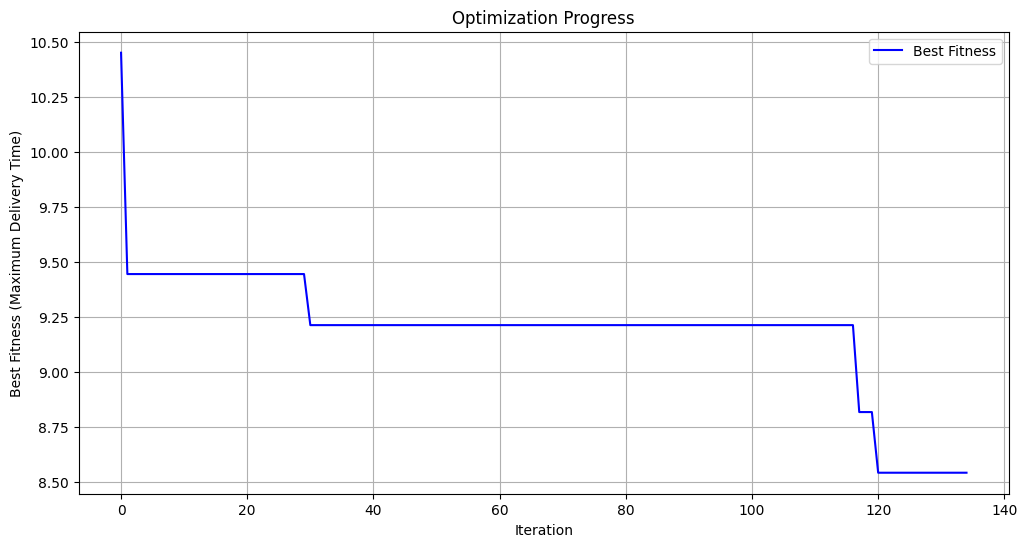


Test completed successfully!


In [138]:
def euclidean_distance(point1, point2):
    """Calculate Euclidean distance between two points"""
    return np.sqrt(np.sum((np.array(point1) - np.array(point2)) ** 2))

def create_distance_matrix(locations):
    """Create distance matrix using Euclidean distance"""
    n = len(locations)
    matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            matrix[i][j] = euclidean_distance(locations[i], locations[j])
    return matrix

def create_charging_distance_matrix(locations, charging_stations):
    """Create distance matrix between locations and charging stations"""
    matrix = np.zeros((len(locations), len(charging_stations)))
    for i, loc in enumerate(locations):
        for j, station in enumerate(charging_stations):
            matrix[i][j] = euclidean_distance(loc, station)
    return matrix

def run_ev_routing_test(toml_file_path):
    # Load and process TOML file
    print(f"Loading data from {toml_file_path}...")
    try:
        data = toml.load(toml_file_path)
        print("Data loaded successfully!")
    except Exception as e:
        print(f"Error loading TOML file: {e}")
        return
    
    # Calculate distance matrices using Euclidean distance
    customer_locations = data['customer_locations']
    charging_stations = data['charging_stations']
    # print(customer_locations)
    
    # Create distance matrices using Euclidean distance
    distance_matrix = create_distance_matrix(customer_locations)
    #print(distance_matrix)
    distance_between_charging_stations_customers = create_charging_distance_matrix(
        customer_locations, charging_stations
    )
    #print(distance_between_charging_stations_customers)
    
    # Initialize algorithm
    print("\nInitializing Simulated Annealing algorithm...")
    sa = SimulatedAnnealingEV(
        initial_temperature=1000,
        cooling_rate=0.95,
        min_temperature=1,
        iterations_per_temp=100
    )
    
    # Set EV parameters (using medium EV type)
    ev_params = data['ev_parameters']['medium']
    num_evs = 2  # Using 2 EVs for this small test case
    
    print("\nSetting algorithm parameters...")
    sa.Set_EV_Parameters(
        num_evs=num_evs,
        initial_charging=100,  # Start with full battery
        ev_base_weight=ev_params['base_weight'],
        ev_speed=data['vehicle_speed'],
        ev_battery_capacity=ev_params['battery_capacity'],
        ev_load_capacity=ev_params['load_capacity']
    )
    
    sa.Set_Charging_Station_Parameters(
        charging_rate=data['charging_rate'],
        charging_cost=1.0  # Example charging cost
    )
    
    sa.Set_Tour_Parameters(
        distance_matrix=distance_matrix,
        distance_between_charging_stations_customers=distance_between_charging_stations_customers,
        num_evs=num_evs,
        customer_locations=np.array(customer_locations),
        charging_station_locations=np.array(charging_stations)
    )
    
    # Set customer parameters
    customer_weights = {str(i): w for i, w in enumerate(data['customer_items_weights'])}
    customer_deadlines = {str(i): float('inf') for i in range(len(data['customer_items_weights']))}
    
    sa.Set_Customer_Parameters(
        customer_items_weights=customer_weights,
        customer_deadlines=customer_deadlines
    )
    
    # Run optimization
    print("\nStarting optimization...")
    print("This may take a few minutes...")
    best_solution, best_fitness = sa.optimize(max_iterations=200)
    
    # Print results
    print("\n=== Optimization Results ===")
    print(f"Best fitness (maximum delivery time): {best_fitness:.2f} hours")
    
    print("\nDetailed route information:")
    total_distance = 0
    total_customers = 0
    
    for i, route in enumerate(best_solution.routes):
        print(f"\nEV {i+1} Route:")
        print("Sequence:", ' -> '.join(map(str, route)))
        print(f"Delivery time: {best_solution.delivery_times[i]:.2f} hours")
        
        # Calculate route statistics using Euclidean distance
        route_distance = sum(euclidean_distance(
            customer_locations[route[j]] if route[j] >= 0 else charging_stations[-route[j]-1],
            customer_locations[route[j+1]] if route[j+1] >= 0 else charging_stations[-route[j+1]-1]
        ) for j in range(len(route)-1))
        
        num_customers = sum(1 for loc in route if loc > 0)
        num_charges = sum(1 for loc in route if loc < 0)
        
        print(f"Distance traveled: {route_distance:.2f} km")
        print(f"Customers served: {num_customers}")
        print(f"Charging stops: {num_charges}")
        
        total_distance += route_distance
        total_customers += num_customers
    
    print("\n=== Overall Statistics ===")
    print(f"Total distance: {total_distance:.2f} km")
    print(f"Total customers served: {total_customers}")
    print(f"Average distance per customer: {total_distance/total_customers:.2f} km")
    
    # Plot fitness history
    plt.figure(figsize=(12, 6))
    plt.plot(sa.best_fitness_history, 'b-', label='Best Fitness')
    plt.title('Optimization Progress')
    plt.xlabel('Iteration')
    plt.ylabel('Best Fitness (Maximum Delivery Time)')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    return sa, best_solution, best_fitness

if __name__ == "__main__":
    toml_path = "/Users/chanakyavasantha/Comsets/test_cases/customers_10/c10_1.toml"
    try:
        sa, solution, fitness = run_ev_routing_test(toml_path)
        print("\nTest completed successfully!")
    except Exception as e:
        print(f"Error during test execution: {str(e)}")

#### Section - 4.2: Main Execution

#### Section 4.3: Parallel Processing Result Execution

### Documentation :


